In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from simulation import simulation
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [98]:
# Intensity parameter
epsilon = .25 # .25 or 1.

r1 = -54.1669
if epsilon == .25:
    r0 = -4.3830
elif epsilon == 1.:
    r0 = -1.0957

# Robustness parameters
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.7

# Grid setting
ϵ = 1.
y_step = .02
y_grid_long = np.linspace(0., 4., int(4/y_step) + 1)
y_grid_short = np.linspace(0., y_bar_upper-y_step, int(2/y_step))
y_grid_tilde = np.linspace(y_bar_lower, y_bar_upper-y_step, int((y_bar_upper-y_bar_lower)/y_step))

In [70]:
# Parallelly solve ODE
model_args_low = []
model_args_high = []
model_args_extreme = []

model_paras_low = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[0], y_bar_upper)

for y_jump in y_grid_tilde:
    model_paras_high = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[1], y_jump)
    model_paras_extreme = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[2], y_jump)
    model_args_high.append((y_grid_long, model_paras_high, None, ϵ, 1e-8, 5000, False))
    model_args_extreme.append((y_grid_long, model_paras_extreme, None, ϵ, 1e-8, 5000, False))

print('----- Solving low damage model -----')
model_low = ode_y(y_grid_long, model_paras_low, None, ϵ, 1e-8, 5000, False)
print('----- Solving high damage models -----')
model_high_list = ode_y_parallel(model_args_high)
print('----- Solving extreme damage models -----')
model_extreme_list = ode_y_parallel(model_args_extreme)

----- Solving low damage model -----
Converged. Total iteration 5000: LHS Error: 2.696741196572816e-05; RHS Error 8.034055397260209e-05
----- Solving high damage models -----
----- Solving extreme damage models -----


In [99]:
# Prepare ϕ_m
ϕ_m = np.zeros((3, len(y_grid_short)))
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
for i in range(len(y_grid_tilde)):
    ϕ_m[0, y_bar_lower_loc+i] = model_low['v0'][y_bar_lower_loc+i]
    ϕ_m[1, y_bar_lower_loc+i] = model_high_list[i]['v0'][y_bar_lower_loc+i]
    ϕ_m[2, y_bar_lower_loc+i] = model_extreme_list[i]['v0'][y_bar_lower_loc+i]

In [100]:
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper-y_step)
temp_1 = model_low['v0'][:y_bar_upper_loc+1]
temp_2 = model_high_list[-1]['v0'][:y_bar_upper_loc+1]
temp_3 = model_extreme_list[-1]['v0'][:y_bar_upper_loc+1]
v_guess = np.average(np.array([temp_1, temp_2, temp_3]), weights=πd_o, axis=0)

In [101]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, epsilon = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = -η*(y_grid+y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = r0 * (np.exp(r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)
        
        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5

        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        g = np.exp(1./ξ_2m*(v0-ϕ_i))

        A = np.ones_like(y_grid)*(-δ)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0) - np.exp(-1./ξ_2m * v0)) \
                / np.exp(-1./ξ_2m * v0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    check = np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0)

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'check': check,
           'πc': πc,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [104]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, epsilon)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=.1,
                                          tol=1e-8, max_iter=10_000, print_all=True)

Iteration 1: LHS Error: 3.6983273835347497; RHS Error 3.698537354499291
Iteration 2: LHS Error: 2.3618759627351427; RHS Error 2.36400335587128
Iteration 3: LHS Error: 1.6942134756307548; RHS Error 1.6988117316486346
Iteration 4: LHS Error: 1.311174652398559; RHS Error 1.3167889260119017
Iteration 5: LHS Error: 1.0699133275793582; RHS Error 1.0756023880330676
Iteration 6: LHS Error: 0.8959809462170942; RHS Error 0.903321874170374
Iteration 7: LHS Error: 0.7834344774953994; RHS Error 0.7892235592408684
Iteration 8: LHS Error: 0.6894930854902304; RHS Error 0.6965359992067987
Iteration 9: LHS Error: 0.6134565428530814; RHS Error 0.6189979048652438
Iteration 10: LHS Error: 0.5631352634344933; RHS Error 0.5697849575423048
Iteration 11: LHS Error: 0.517285959725855; RHS Error 0.524951115929944
Iteration 12: LHS Error: 0.4754326980815149; RHS Error 0.48404254927686713
Iteration 13: LHS Error: 0.4371646211975577; RHS Error 0.4466613337382692
Iteration 14: LHS Error: 0.402857357548867; RHS Error

Iteration 180: LHS Error: 0.05463312403601428; RHS Error 0.05364488337569834
Iteration 181: LHS Error: 0.05450915220381658; RHS Error 0.053279290797001534
Iteration 182: LHS Error: 0.054389228501841025; RHS Error 0.05291408593388698
Iteration 183: LHS Error: 0.05427861388507704; RHS Error 0.05254914926001966
Iteration 184: LHS Error: 0.054176339955713804; RHS Error 0.05218432537119222
Iteration 185: LHS Error: 0.054079388284036245; RHS Error 0.05181947021072368
Iteration 186: LHS Error: 0.05398485983359791; RHS Error 0.05145446491998007
Iteration 187: LHS Error: 0.05389066362774697; RHS Error 0.051089213592962535
Iteration 188: LHS Error: 0.053795511183580835; RHS Error 0.05072363643988996
Iteration 189: LHS Error: 0.053698699665458705; RHS Error 0.050357663389397525
Iteration 190: LHS Error: 0.05359989380782748; RHS Error 0.04999122950373443
Iteration 191: LHS Error: 0.05349896662817599; RHS Error 0.04962427209305276
Iteration 192: LHS Error: 0.05339589866794281; RHS Error 0.049256729

Iteration 368: LHS Error: 0.03516054368051247; RHS Error 0.03252970576438647
Iteration 369: LHS Error: 0.0350718463887012; RHS Error 0.032444499048922874
Iteration 370: LHS Error: 0.034981370190476646; RHS Error 0.032357647233136284
Iteration 371: LHS Error: 0.03488910003168977; RHS Error 0.03226913009989292
Iteration 372: LHS Error: 0.034795021346620825; RHS Error 0.03217892730900821
Iteration 373: LHS Error: 0.034699119971386416; RHS Error 0.0320870184068245
Iteration 374: LHS Error: 0.0346013820607749; RHS Error 0.031993382836663586
Iteration 375: LHS Error: 0.03450179400707576; RHS Error 0.031897999950196765
Iteration 376: LHS Error: 0.03440034236381173; RHS Error 0.031834719041782124
Iteration 377: LHS Error: 0.0342970137732479; RHS Error 0.03179820139669094
Iteration 378: LHS Error: 0.03419179489965396; RHS Error 0.03176072174180809
Iteration 379: LHS Error: 0.034084672368384084; RHS Error 0.03172226832374414
Iteration 380: LHS Error: 0.034029279724501205; RHS Error 0.03168282919

Iteration 550: LHS Error: 0.025120494069668098; RHS Error 0.023525723508222973
Iteration 551: LHS Error: 0.02507135968541352; RHS Error 0.023476971835083384
Iteration 552: LHS Error: 0.02502128902079015; RHS Error 0.023427320571457456
Iteration 553: LHS Error: 0.024970272283886263; RHS Error 0.023376760352451224
Iteration 554: LHS Error: 0.024918299678253764; RHS Error 0.023325281811889018
Iteration 555: LHS Error: 0.02486536140886564; RHS Error 0.023280896613036554
Iteration 556: LHS Error: 0.024811447687971278; RHS Error 0.023254992334705852
Iteration 557: LHS Error: 0.024756548741378115; RHS Error 0.023228481979644944
Iteration 558: LHS Error: 0.024700654814604484; RHS Error 0.02320135843984433
Iteration 559: LHS Error: 0.024657350498895614; RHS Error 0.023173614533883825
Iteration 560: LHS Error: 0.024629359860717237; RHS Error 0.023145243008053616
Iteration 561: LHS Error: 0.024600709591811043; RHS Error 0.023116236537571402
Iteration 562: LHS Error: 0.024571391999110848; RHS Erro

Iteration 736: LHS Error: 0.01880047299612997; RHS Error 0.01774195199435329
Iteration 737: LHS Error: 0.018778239607009084; RHS Error 0.017719469747647962
Iteration 738: LHS Error: 0.018755557909440057; RHS Error 0.01769655317323049
Iteration 739: LHS Error: 0.01873242309216483; RHS Error 0.01767319768628964
Iteration 740: LHS Error: 0.018708830315827818; RHS Error 0.0176493986781391
Iteration 741: LHS Error: 0.018684774714419206; RHS Error 0.017625151517611067
Iteration 742: LHS Error: 0.018660251396687144; RHS Error 0.01760045155251834
Iteration 743: LHS Error: 0.018635255447474464; RHS Error 0.01757529411118545
Iteration 744: LHS Error: 0.01860978192940621; RHS Error 0.017549674504048964
Iteration 745: LHS Error: 0.018583825884572747; RHS Error 0.017523588025328676
Iteration 746: LHS Error: 0.01855738233587978; RHS Error 0.017497029954774868
Iteration 747: LHS Error: 0.018530446289193314; RHS Error 0.017469995559487767
Iteration 748: LHS Error: 0.01850301273488064; RHS Error 0.0174

Iteration 927: LHS Error: 0.01441617261420891; RHS Error 0.013649564756991646
Iteration 928: LHS Error: 0.01439968860244889; RHS Error 0.013632941534958545
Iteration 929: LHS Error: 0.014382909426817747; RHS Error 0.01361603181745541
Iteration 930: LHS Error: 0.014365832217637653; RHS Error 0.013598832872399706
Iteration 931: LHS Error: 0.014348454094901264; RHS Error 0.013581341959616314
Iteration 932: LHS Error: 0.0143307721693553; RHS Error 0.013563556331702836
Iteration 933: LHS Error: 0.014312783543175556; RHS Error 0.013545473234925623
Iteration 934: LHS Error: 0.014294485310988314; RHS Error 0.013527089910149719
Iteration 935: LHS Error: 0.014275874560789603; RHS Error 0.013508403593801857
Iteration 936: LHS Error: 0.014256948374971046; RHS Error 0.01348941151886826
Iteration 937: LHS Error: 0.014237703831252446; RHS Error 0.013470110915925405
Iteration 938: LHS Error: 0.014218138003849745; RHS Error 0.013450499014207966
Iteration 939: LHS Error: 0.014198247964447575; RHS Error 

Iteration 1115: LHS Error: 0.011302117325837635; RHS Error 0.010913561027631882
Iteration 1116: LHS Error: 0.011287517445057738; RHS Error 0.010913620166862415
Iteration 1117: LHS Error: 0.011272696074264843; RHS Error 0.010913679659769797
Iteration 1118: LHS Error: 0.011257651391822776; RHS Error 0.010913739503787434
Iteration 1119: LHS Error: 0.011242381577916127; RHS Error 0.010913799696344123
Iteration 1120: LHS Error: 0.01122688481523415; RHS Error 0.010913860234863213
Iteration 1121: LHS Error: 0.011211159289650219; RHS Error 0.010913921116764463
Iteration 1122: LHS Error: 0.011195203190972336; RHS Error 0.010913982339462568
Iteration 1123: LHS Error: 0.011179014713724733; RHS Error 0.010914043900368306
Iteration 1124: LHS Error: 0.011166542927978362; RHS Error 0.010914105796889562
Iteration 1125: LHS Error: 0.01115420419139479; RHS Error 0.010914168026429628
Iteration 1126: LHS Error: 0.011141667723020277; RHS Error 0.01091423058639
Iteration 1127: LHS Error: 0.01112893179363805

Iteration 1303: LHS Error: 0.008954158992926509; RHS Error 0.010928254368442365
Iteration 1304: LHS Error: 0.008942443476471773; RHS Error 0.010928339614162522
Iteration 1305: LHS Error: 0.008930568864844446; RHS Error 0.010928424836084548
Iteration 1306: LHS Error: 0.00891854412623072; RHS Error 0.01092851003315741
Iteration 1307: LHS Error: 0.008908895051646937; RHS Error 0.0109285952043402
Iteration 1308: LHS Error: 0.008899105086879189; RHS Error 0.010928680348600641
Iteration 1309: LHS Error: 0.00888917311556714; RHS Error 0.010928765464916654
Iteration 1310: LHS Error: 0.00887909802079534; RHS Error 0.010928850552275125
Iteration 1311: LHS Error: 0.008868878685408532; RHS Error 0.010928935609673444
Iteration 1312: LHS Error: 0.008858513992269224; RHS Error 0.01092902063611818
Iteration 1313: LHS Error: 0.008848002824723977; RHS Error 0.010929105630624669
Iteration 1314: LHS Error: 0.008837344066758845; RHS Error 0.010929190592218328
Iteration 1315: LHS Error: 0.008826536603590007

Iteration 1491: LHS Error: 0.007156151457916593; RHS Error 0.010943125988589396
Iteration 1492: LHS Error: 0.0071482063277494845; RHS Error 0.010943196734667773
Iteration 1493: LHS Error: 0.007140156407690057; RHS Error 0.010943267385727925
Iteration 1494: LHS Error: 0.0071320009640318816; RHS Error 0.010943337941887794
Iteration 1495: LHS Error: 0.0071237392641698705; RHS Error 0.010943408403270106
Iteration 1496: LHS Error: 0.007115370576968871; RHS Error 0.01094347877000108
Iteration 1497: LHS Error: 0.007106894172821399; RHS Error 0.01094354904221172
Iteration 1498: LHS Error: 0.007098309323985141; RHS Error 0.010943619220037344
Iteration 1499: LHS Error: 0.00708961530481389; RHS Error 0.0109436893036165
Iteration 1500: LHS Error: 0.00708081139193073; RHS Error 0.01094375929309345
Iteration 1501: LHS Error: 0.007071896864516702; RHS Error 0.010943829188615271
Iteration 1502: LHS Error: 0.007063339247750378; RHS Error 0.010943898990334218
Iteration 1503: LHS Error: 0.007055706579039

Iteration 1677: LHS Error: 0.005768578994969076; RHS Error 0.010955007173424167
Iteration 1678: LHS Error: 0.005761550411262917; RHS Error 0.010955067687445516
Iteration 1679: LHS Error: 0.00575533224335345; RHS Error 0.010955128227369503
Iteration 1680: LHS Error: 0.005749091541122908; RHS Error 0.010955188794676385
Iteration 1681: LHS Error: 0.0057427744412397175; RHS Error 0.010955249390859793
Iteration 1682: LHS Error: 0.005736380460215074; RHS Error 0.010955310017426473
Iteration 1683: LHS Error: 0.005729909115705922; RHS Error 0.010955370675897379
Iteration 1684: LHS Error: 0.00572335992691464; RHS Error 0.010955431367806863
Iteration 1685: LHS Error: 0.005716732414535741; RHS Error 0.010955492094702271
Iteration 1686: LHS Error: 0.0057100261010401; RHS Error 0.01095555285814611
Iteration 1687: LHS Error: 0.005703240510674945; RHS Error 0.010955613659714012
Iteration 1688: LHS Error: 0.005696375169712553; RHS Error 0.010955674500995487
Iteration 1689: LHS Error: 0.005689594625621

Iteration 1866: LHS Error: 0.0044615554633331556; RHS Error 0.010969179458932901
Iteration 1867: LHS Error: 0.004450535345821294; RHS Error 0.010969281901106794
Iteration 1868: LHS Error: 0.004439435352034948; RHS Error 0.010969384691250434
Iteration 1869: LHS Error: 0.004428255571466977; RHS Error 0.010969487826517067
Iteration 1870: LHS Error: 0.00441699610527202; RHS Error 0.010969591303900097
Iteration 1871: LHS Error: 0.004405657066408608; RHS Error 0.01096969512022937
Iteration 1872: LHS Error: 0.004394238579807919; RHS Error 0.010969799272168172
Iteration 1873: LHS Error: 0.004382740782373773; RHS Error 0.0109699037562117
Iteration 1874: LHS Error: 0.004371163823204682; RHS Error 0.010970008568683798
Iteration 1875: LHS Error: 0.004359507863638257; RHS Error 0.010970113705734728
Iteration 1876: LHS Error: 0.004347773077348904; RHS Error 0.010970219163338006
Iteration 1877: LHS Error: 0.004335959650454413; RHS Error 0.010970324937289704
Iteration 1878: LHS Error: 0.00432406778164

Iteration 2052: LHS Error: 0.0016752854618840018; RHS Error 0.010982917564877629
Iteration 2053: LHS Error: 0.0016614825671457112; RHS Error 0.01098288277272778
Iteration 2054: LHS Error: 0.001647744219388514; RHS Error 0.010982846332816792
Iteration 2055: LHS Error: 0.0016340708433215667; RHS Error 0.010982808252365975
Iteration 2056: LHS Error: 0.0016204628514326913; RHS Error 0.01098276853897033
Iteration 2057: LHS Error: 0.0016069206438107386; RHS Error 0.010982727200595854
Iteration 2058: LHS Error: 0.0015934446084120424; RHS Error 0.010982684245574699
Iteration 2059: LHS Error: 0.0015800351210160102; RHS Error 0.010982639682599042
Iteration 2060: LHS Error: 0.0015666925451540692; RHS Error 0.010982593520718974
Iteration 2061: LHS Error: 0.0015534172323405926; RHS Error 0.010982545769335949
Iteration 2062: LHS Error: 0.0015402095220373724; RHS Error 0.01098249643819759
Iteration 2063: LHS Error: 0.0015270697417069101; RHS Error 0.010982445537394248
Iteration 2064: LHS Error: 0.001

Iteration 2240: LHS Error: 0.0002262664091023936; RHS Error 0.010963362327583683
Iteration 2241: LHS Error: 0.00022336990573634807; RHS Error 0.010963268836993088
Iteration 2242: LHS Error: 0.0002205046131908972; RHS Error 0.010963175942784863
Iteration 2243: LHS Error: 0.0002176702462808322; RHS Error 0.010963083645724927
Iteration 2244: LHS Error: 0.00021486652163282827; RHS Error 0.010962991946476045
Iteration 2245: LHS Error: 0.0002120931575610996; RHS Error 0.010962900845600868
Iteration 2246: LHS Error: 0.00020934987413845363; RHS Error 0.010962810343563674
Iteration 2247: LHS Error: 0.00020663639324070004; RHS Error 0.010962720440730017
Iteration 2248: LHS Error: 0.00020395243840454214; RHS Error 0.01096263113737115
Iteration 2249: LHS Error: 0.00020129773500521253; RHS Error 0.010962542433663
Iteration 2250: LHS Error: 0.00019867201017653713; RHS Error 0.010962454329690556
Iteration 2251: LHS Error: 0.00019607499277540796; RHS Error 0.010962366825447267
Iteration 2252: LHS Erro

Iteration 2427: LHS Error: 1.7417998490198983e-05; RHS Error 0.010954453520414478
Iteration 2428: LHS Error: 1.740385614734663e-05; RHS Error 0.010954437344317787
Iteration 2429: LHS Error: 1.738908768977865e-05; RHS Error 0.010954421349860508
Iteration 2430: LHS Error: 1.7373697402955912e-05; RHS Error 0.01095440553520179
Iteration 2431: LHS Error: 1.7357689636732232e-05; RHS Error 0.010954389898515493
Iteration 2432: LHS Error: 1.734106876760677e-05; RHS Error 0.010954374437990085
Iteration 2433: LHS Error: 1.7323839152094678e-05; RHS Error 0.010954359151828037
Iteration 2434: LHS Error: 1.7306005202222252e-05; RHS Error 0.010954344038247972
Iteration 2435: LHS Error: 1.7287571392188283e-05; RHS Error 0.010954329095483582
Iteration 2436: LHS Error: 1.7268542178427992e-05; RHS Error 0.010954314321781702
Iteration 2437: LHS Error: 1.724892207954909e-05; RHS Error 0.010954299715404799
Iteration 2438: LHS Error: 1.7228715609718392e-05; RHS Error 0.010954285274629431
Iteration 2439: LHS E

Iteration 2614: LHS Error: 1.3590635905558202e-05; RHS Error 0.01095322493323327
Iteration 2615: LHS Error: 1.3574914712322084e-05; RHS Error 0.010953223259076827
Iteration 2616: LHS Error: 1.3558838487526259e-05; RHS Error 0.01095322160617378
Iteration 2617: LHS Error: 1.354240950046659e-05; RHS Error 0.01095321997426513
Iteration 2618: LHS Error: 1.3525630095934105e-05; RHS Error 0.01095321836309521
Iteration 2619: LHS Error: 1.3508502592074478e-05; RHS Error 0.010953216772410238
Iteration 2620: LHS Error: 1.3491029333678739e-05; RHS Error 0.010953215201960333
Iteration 2621: LHS Error: 1.3473212683301483e-05; RHS Error 0.010953213651498536
Iteration 2622: LHS Error: 1.345505503014266e-05; RHS Error 0.010953212120780976
Iteration 2623: LHS Error: 1.3436558776724894e-05; RHS Error 0.010953210609565903
Iteration 2624: LHS Error: 1.3417726316689027e-05; RHS Error 0.010953209117615041
Iteration 2625: LHS Error: 1.3398560079203037e-05; RHS Error 0.010953207644693066
Iteration 2626: LHS Er

Iteration 2800: LHS Error: 1.0542987860517883e-05; RHS Error 0.01095310853342446
Iteration 2801: LHS Error: 1.0528905698414803e-05; RHS Error 0.010953108411871273
Iteration 2802: LHS Error: 1.051459184608916e-05; RHS Error 0.010953108292389498
Iteration 2803: LHS Error: 1.0500047884498542e-05; RHS Error 0.01095310817495218
Iteration 2804: LHS Error: 1.048527542568678e-05; RHS Error 0.010953108059533354
Iteration 2805: LHS Error: 1.0470276086138597e-05; RHS Error 0.010953107946106811
Iteration 2806: LHS Error: 1.0455051491220502e-05; RHS Error 0.010953107834647813
Iteration 2807: LHS Error: 1.043960328406257e-05; RHS Error 0.010953107725130407
Iteration 2808: LHS Error: 1.0423933081149528e-05; RHS Error 0.01095310761752933
Iteration 2809: LHS Error: 1.0408042561138586e-05; RHS Error 0.010953107511820666
Iteration 2810: LHS Error: 1.0396012664060095e-05; RHS Error 0.01095310740797905
Iteration 2811: LHS Error: 1.0383781394729397e-05; RHS Error 0.010953107305981147
Iteration 2812: LHS Err

Iteration 2988: LHS Error: 8.23377749537002e-06; RHS Error 0.010953104558782425
Iteration 2989: LHS Error: 8.22262128163942e-06; RHS Error 0.010953104588685786
Iteration 2990: LHS Error: 8.211302953142763e-06; RHS Error 0.01095310461894785
Iteration 2991: LHS Error: 8.199823620103075e-06; RHS Error 0.010953104649570129
Iteration 2992: LHS Error: 8.18818443271141e-06; RHS Error 0.010953104680553914
Iteration 2993: LHS Error: 8.177580625989833e-06; RHS Error 0.010953104711901161
Iteration 2994: LHS Error: 8.168168079691895e-06; RHS Error 0.010953104743613152
Iteration 2995: LHS Error: 8.158587481155166e-06; RHS Error 0.010953104775691981
Iteration 2996: LHS Error: 8.148839851784828e-06; RHS Error 0.010953104808139054
Iteration 2997: LHS Error: 8.1389262485132e-06; RHS Error 0.01095310484095674
Iteration 2998: LHS Error: 8.128847746036172e-06; RHS Error 0.010953104874146677
Iteration 2999: LHS Error: 8.118605383522493e-06; RHS Error 0.010953104907711082
Iteration 3000: LHS Error: 8.108200

Iteration 3173: LHS Error: 6.515521118188872e-06; RHS Error 0.010953119768354495
Iteration 3174: LHS Error: 6.507053682547337e-06; RHS Error 0.010953119926848533
Iteration 3175: LHS Error: 6.498466871285302e-06; RHS Error 0.010953120086365141
Iteration 3176: LHS Error: 6.489761448236209e-06; RHS Error 0.01095312024690492
Iteration 3177: LHS Error: 6.481355709908598e-06; RHS Error 0.010953120408469446
Iteration 3178: LHS Error: 6.47402463638258e-06; RHS Error 0.010953120571059155
Iteration 3179: LHS Error: 6.4665701193789005e-06; RHS Error 0.010953120734674561
Iteration 3180: LHS Error: 6.458992913849215e-06; RHS Error 0.010953120899316483
Iteration 3181: LHS Error: 6.451293805831426e-06; RHS Error 0.01095312106498593
Iteration 3182: LHS Error: 6.443473559158974e-06; RHS Error 0.010953121231682746
Iteration 3183: LHS Error: 6.435532950987977e-06; RHS Error 0.010953121399407486
Iteration 3184: LHS Error: 6.42747273627009e-06; RHS Error 0.010953121568160546
Iteration 3185: LHS Error: 6.41

Iteration 3360: LHS Error: 5.18777832247963e-06; RHS Error 0.010953164132707482
Iteration 3361: LHS Error: 5.18170779173488e-06; RHS Error 0.01095316441224872
Iteration 3362: LHS Error: 5.175545556568295e-06; RHS Error 0.010953164691669862
Iteration 3363: LHS Error: 5.169292185414065e-06; RHS Error 0.010953164970960726
Iteration 3364: LHS Error: 5.162948299997083e-06; RHS Error 0.01095316525011025
Iteration 3365: LHS Error: 5.1565144243426175e-06; RHS Error 0.01095316552910813
Iteration 3366: LHS Error: 5.149991189057346e-06; RHS Error 0.010953165807944691
Iteration 3367: LHS Error: 5.14337912704832e-06; RHS Error 0.01095316608660922
Iteration 3368: LHS Error: 5.137659258025451e-06; RHS Error 0.010953166365090913
Iteration 3369: LHS Error: 5.13188078699045e-06; RHS Error 0.010953166643379423
Iteration 3370: LHS Error: 5.1260107358785945e-06; RHS Error 0.010953166921464568
Iteration 3371: LHS Error: 5.1200496109515825e-06; RHS Error 0.010953167199336054
Iteration 3372: LHS Error: 5.1139

Iteration 3548: LHS Error: 3.8248351419412074e-06; RHS Error 0.010953204960509628
Iteration 3549: LHS Error: 3.814031384052896e-06; RHS Error 0.010953205078163112
Iteration 3550: LHS Error: 3.803199497554033e-06; RHS Error 0.010953205194583555
Iteration 3551: LHS Error: 3.79233995317918e-06; RHS Error 0.01095320530977141
Iteration 3552: LHS Error: 3.7814533104807424e-06; RHS Error 0.010953205423727474
Iteration 3553: LHS Error: 3.770540031311498e-06; RHS Error 0.01095320553645317
Iteration 3554: LHS Error: 3.759600639696714e-06; RHS Error 0.010953205647948824
Iteration 3555: LHS Error: 3.748635633016306e-06; RHS Error 0.010953205758215123
Iteration 3556: LHS Error: 3.737645508650189e-06; RHS Error 0.010953205867253332
Iteration 3557: LHS Error: 3.7266307906236307e-06; RHS Error 0.010953205975064936
Iteration 3558: LHS Error: 3.7155919319076247e-06; RHS Error 0.010953206081650797
Iteration 3559: LHS Error: 3.7045294742910073e-06; RHS Error 0.01095320618701225
Iteration 3560: LHS Error: 

Iteration 3733: LHS Error: 1.781488787599983e-06; RHS Error 0.010953208894970663
Iteration 3734: LHS Error: 1.7719901812540684e-06; RHS Error 0.010953208845145834
Iteration 3735: LHS Error: 1.76252070716032e-06; RHS Error 0.01095320879488906
Iteration 3736: LHS Error: 1.7530804541365796e-06; RHS Error 0.010953208744205325
Iteration 3737: LHS Error: 1.7436695287642578e-06; RHS Error 0.010953208693099802
Iteration 3738: LHS Error: 1.7342880109794123e-06; RHS Error 0.010953208641577287
Iteration 3739: LHS Error: 1.7249359984816692e-06; RHS Error 0.010953208589644037
Iteration 3740: LHS Error: 1.7156135889706547e-06; RHS Error 0.010953208537304398
Iteration 3741: LHS Error: 1.7063208179735057e-06; RHS Error 0.010953208484564096
Iteration 3742: LHS Error: 1.697057818716985e-06; RHS Error 0.010953208431428045
Iteration 3743: LHS Error: 1.6878246267282293e-06; RHS Error 0.010953208377901934
Iteration 3744: LHS Error: 1.6786213485886492e-06; RHS Error 0.010953208323990184
Iteration 3745: LHS E

Iteration 3921: LHS Error: 5.294921479048753e-07; RHS Error 0.010953196658511438
Iteration 3922: LHS Error: 5.254947854638203e-07; RHS Error 0.010953196597127221
Iteration 3923: LHS Error: 5.21521075214082e-07; RHS Error 0.010953196535914745
Iteration 3924: LHS Error: 5.175709016924657e-07; RHS Error 0.010953196474874957
Iteration 3925: LHS Error: 5.136441671993452e-07; RHS Error 0.010953196414008683
Iteration 3926: LHS Error: 5.097408006804471e-07; RHS Error 0.010953196353316992
Iteration 3927: LHS Error: 5.058607044361452e-07; RHS Error 0.010953196292801184
Iteration 3928: LHS Error: 5.020037807668132e-07; RHS Error 0.01095319623246177
Iteration 3929: LHS Error: 4.98169931972825e-07; RHS Error 0.010953196172299642
Iteration 3930: LHS Error: 4.94359086999907e-07; RHS Error 0.010953196112316113
Iteration 3931: LHS Error: 4.905711481484332e-07; RHS Error 0.010953196052511664
Iteration 3932: LHS Error: 4.868059910734246e-07; RHS Error 0.010953195992887264
Iteration 3933: LHS Error: 4.830

Iteration 4109: LHS Error: 9.594806726909155e-08; RHS Error 0.010953188519142107
Iteration 4110: LHS Error: 9.48677492118577e-08; RHS Error 0.01095318849331835
Iteration 4111: LHS Error: 9.379598431280556e-08; RHS Error 0.01095318846765041
Iteration 4112: LHS Error: 9.273267487230896e-08; RHS Error 0.01095318844213792
Iteration 4113: LHS Error: 9.167779424501532e-08; RHS Error 0.010953188416779787
Iteration 4114: LHS Error: 9.063125361308266e-08; RHS Error 0.010953188391576035
Iteration 4115: LHS Error: 8.95930174493742e-08; RHS Error 0.010953188366525805
Iteration 4116: LHS Error: 8.856301469961636e-08; RHS Error 0.01095318834162793
Iteration 4117: LHS Error: 8.754122760024075e-08; RHS Error 0.01095318831688247
Iteration 4118: LHS Error: 8.65275406880528e-08; RHS Error 0.010953188292288661
Iteration 4119: LHS Error: 8.552196284483671e-08; RHS Error 0.010953188267845498
Iteration 4120: LHS Error: 8.452438748918212e-08; RHS Error 0.010953188243552858
Iteration 4121: LHS Error: 8.3534796

Iteration 4297: LHS Error: 2.3719453068338225e-08; RHS Error 0.01095318573539078
Iteration 4298: LHS Error: 2.3688260242238357e-08; RHS Error 0.010953185728418673
Iteration 4299: LHS Error: 2.3662170001159666e-08; RHS Error 0.010953185721499122
Iteration 4300: LHS Error: 2.363555573481335e-08; RHS Error 0.010953185714632236
Iteration 4301: LHS Error: 2.3608448529444104e-08; RHS Error 0.010953185707817722
Iteration 4302: LHS Error: 2.358082618059143e-08; RHS Error 0.010953185701054954
Iteration 4303: LHS Error: 2.3552666483794837e-08; RHS Error 0.010953185694343257
Iteration 4304: LHS Error: 2.352401828886741e-08; RHS Error 0.01095318568768314
Iteration 4305: LHS Error: 2.3494881595809147e-08; RHS Error 0.010953185681073709
Iteration 4306: LHS Error: 2.3465238641051656e-08; RHS Error 0.010953185674514244
Iteration 4307: LHS Error: 2.343510718816333e-08; RHS Error 0.010953185668005523
Iteration 4308: LHS Error: 2.340448279625207e-08; RHS Error 0.01095318566154628
Iteration 4309: LHS Erro

Iteration 4485: LHS Error: 1.8792238876130796e-08; RHS Error 0.010953185041307444
Iteration 4486: LHS Error: 1.8770167642401248e-08; RHS Error 0.010953185039679191
Iteration 4487: LHS Error: 1.8747696728382834e-08; RHS Error 0.01095318503806365
Iteration 4488: LHS Error: 1.8724763961586177e-08; RHS Error 0.01095318503646028
Iteration 4489: LHS Error: 1.8701440396284852e-08; RHS Error 0.010953185034869684
Iteration 4490: LHS Error: 1.8677699387126268e-08; RHS Error 0.010953185033291141
Iteration 4491: LHS Error: 1.8653532052326227e-08; RHS Error 0.01095318503172477
Iteration 4492: LHS Error: 1.8628965037237322e-08; RHS Error 0.010953185030170641
Iteration 4493: LHS Error: 1.8603936169370172e-08; RHS Error 0.010953185028628524
Iteration 4494: LHS Error: 1.8579999760959254e-08; RHS Error 0.010953185027098543
Iteration 4495: LHS Error: 1.8558621306397072e-08; RHS Error 0.010953185025580327
Iteration 4496: LHS Error: 1.8536834289761828e-08; RHS Error 0.010953185024073869
Iteration 4497: LHS

Iteration 4672: LHS Error: 1.0975798048207253e-08; RHS Error 0.010953184888253392
Iteration 4673: LHS Error: 1.0919629644945417e-08; RHS Error 0.010953184888012585
Iteration 4674: LHS Error: 1.0863407950978399e-08; RHS Error 0.010953184887775826
Iteration 4675: LHS Error: 1.0807132966306199e-08; RHS Error 0.010953184887543974
Iteration 4676: LHS Error: 1.0750857981633999e-08; RHS Error 0.010953184887316721
Iteration 4677: LHS Error: 1.0694529706256617e-08; RHS Error 0.010953184887093452
Iteration 4678: LHS Error: 1.0638165903742447e-08; RHS Error 0.010953184886874627
Iteration 4679: LHS Error: 1.058179321944408e-08; RHS Error 0.010953184886660545
Iteration 4680: LHS Error: 1.0525367244440531e-08; RHS Error 0.010953184886450602
Iteration 4681: LHS Error: 1.0468932387652785e-08; RHS Error 0.01095318488624502
Iteration 4682: LHS Error: 1.0412470885512448e-08; RHS Error 0.01095318488604392
Iteration 4683: LHS Error: 1.0355991619803717e-08; RHS Error 0.010953184885847074
Iteration 4684: LHS

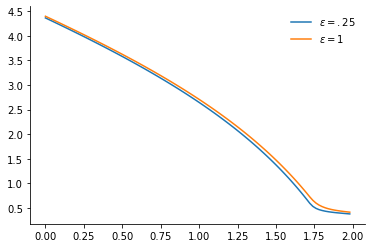

In [110]:
plt.plot(y_grid_short, model_res['v0'], label=r'$\epsilon=.25$')
plt.plot(y_grid_short, temp, label=r'$\epsilon=1$')
plt.legend(frameon=False)

In [106]:
temp - model_res['v0']

array([0.03374682, 0.0340782 , 0.03440389, 0.0347354 , 0.03507446,
       0.03542007, 0.03577231, 0.03613137, 0.03649742, 0.03687064,
       0.03725121, 0.03763933, 0.03803517, 0.03843896, 0.0388509 ,
       0.03927121, 0.03970012, 0.04013785, 0.04058467, 0.04104081,
       0.04150654, 0.04198214, 0.04246788, 0.04296408, 0.04347102,
       0.04398903, 0.04451845, 0.04505962, 0.04561289, 0.04617866,
       0.0467573 , 0.04734923, 0.04795487, 0.04857467, 0.04920909,
       0.04985862, 0.05052376, 0.05120505, 0.05190304, 0.05261832,
       0.05335148, 0.05410317, 0.05487406, 0.05566485, 0.05647628,
       0.05730911, 0.05816417, 0.0590423 , 0.05994442, 0.06087145,
       0.06182441, 0.06280435, 0.06381237, 0.06484965, 0.06591744,
       0.06701703, 0.06814981, 0.06931726, 0.07052094, 0.07176249,
       0.07304367, 0.07436635, 0.0757325 , 0.07714425, 0.07860385,
       0.0801137 , 0.08167637, 0.08329461, 0.08497135, 0.08670976,
       0.08851321, 0.09038534, 0.09233007, 0.09435161, 0.09645

1.0